In [1]:
import os
import collections
import functools
import pickle
import PIL
from glob import glob

import numpy as np
import cv2

from skimage.morphology import skeletonize
from sklearn.preprocessing import StandardScaler

import networkx as nx

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [2]:
def show(img, show_=True):
    max_edge = 8.0
    alpha = max_edge / max(img.shape[0], img.shape[1])
    size = (alpha * img.shape[1], alpha * img.shape[0])
    plt.figure(figsize=size)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(change_rgb(img))
    plt.axis('off')
    if show_:
        plt.show()

def rescale(img, new_shape):
    if not isinstance(new_shape, tuple):
        width = round(img.shape[1] * new_shape)
        height = round(img.shape[0] * new_shape)
        new_shape = (width, height)
    return cv2.resize(img, new_shape, interpolation=cv2.INTER_CUBIC)

def change_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def bgr_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def opening(n):
    kernel = np.ones((n, n), dtype=np.uint8)
    
    def wrapper(img):
        return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    return wrapper

def closing(n):
    kernel = np.ones((n, n), dtype=np.uint8)
    
    def wrapper(img):
        return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    return wrapper

def dilate(n):
    kernel = np.ones((n, n), dtype=np.uint8)
    
    def wrapper(img):
        return cv2.dilate(img, kernel, iterations=1)
    
    return wrapper

def erode(n):
    kernel = np.ones((n, n), dtype=np.uint8)
    
    def wrapper(img):
        return cv2.erode(img, kernel, iterations=1)
    
    return wrapper

def bitwise_or(imgs):
    res = imgs[0]
    for img in imgs[1:]:
        res = cv2.bitwise_or(res, img)
    return res

def bitwise_and(imgs):
    res = imgs[0]
    for img in imgs[1:]:
        res = cv2.bitwise_and(res, img)
    return res

def get_masked_image(img, contours, do_dilate=None):
    mask = np.zeros(img.shape, dtype=np.uint8)
    mask = cv2.drawContours(mask, contours, -1, color=(255, 255, 255), thickness=cv2.FILLED)
    if do_dilate is not None:
        mask = dilate(do_dilate)(mask)
    return cv2.bitwise_and(img, mask)

def leave_only_area_threshold_contours(threshold, inv=False):
    def wrapper(contours):
        if not inv:
            return list(filter(lambda x: cv2.contourArea(x) >= threshold, contours))
        else:
            return list(filter(lambda x: cv2.contourArea(x) < threshold, contours))
    return wrapper

def threshold(low, high, is_invert=False):
    mode = cv2.THRESH_BINARY_INV if is_invert else cv2.THRESH_BINARY
    
    def wrapper(img):
        _, img_thr = cv2.threshold(img, low, high, mode)
        return img_thr
    
    return wrapper

def kirshe_operator(img):
    def rotate(arr):
        n = arr.shape[0]
        res = np.array(arr)
        res[0, :n - 1] = arr[0, 1:n]
        res[1:n, 0] = arr[:n - 1, 0]
        res[n - 1, 1:n] = arr[n - 1, :n - 1]
        res[:n - 1, n - 1] = arr[1:n, n - 1]
        return res
    
    kernel = np.array([
        [-3, -3, 5],
        [-3, 0, 5],
        [-3, -3, 5]
    ])
    kernels = []
    for _ in range(8):
        kernels.append(kernel)
        kernel = rotate(kernel)
    
    imgs = [np.abs(cv2.filter2D(img, -1, kernel)) for kernel in kernels] 
    return functools.reduce(np.maximum, imgs, np.zeros(img.shape, dtype=np.uint8))

In [3]:
def get_areas(contours):
    return np.array(list(map(cv2.contourArea, contours)))

def find_black(img, contours=None, c=18):
    hsv = bgr_to_hsv(img)
    sm = ((0, 0, 0), (255, 255, c))
    # sm = ((0, 48, 0), (255, 191, 32))
    mask = cv2.inRange(hsv, *sm)
    if contours is not None:
        mask = mask_all_contours(mask, contours, 0)
    return mask

def find_light_green(img, contours=None, is_inter=False):
    hsv = bgr_to_hsv(img)
    masks = []
    masks.append(cv2.inRange(hsv, (77, 27, 120), (255, 255, 255)))
    if is_inter:
        masks.append(cv2.inRange(hsv, (41, 20, 20), (70, 255, 255)))
        masks.append(cv2.inRange(hsv, (27, 23, 21), (63, 134, 153)))
    else:
        masks.append(cv2.inRange(hsv, (81, 30, 108), (100, 114, 253)))
        masks.append(cv2.inRange(hsv, (54, 23, 110), (110, 110, 255)))
        masks.append(cv2.inRange(hsv, (45, 45, 27), (93, 115, 233)))
    mask = bitwise_or(masks)
    if contours is not None:
        mask = mask_all_contours(mask, contours, 0)
    return mask

def find_contours(img):
    contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    return contours, hierarchy

def get_circles(contours):
    return [cv2.minEnclosingCircle(contour) for contour in contours]

def get_all_black_circles(colored_image, c=33, close_to=None):
    colored_image = rescale(rescale(colored_image, 0.75), 1 / 0.75)
    mask = opening(3)(find_black(colored_image, c=c))
    if close_to is not None:
        contours, _ = find_contours(mask)
        res = []
        for contour in contours:
            if minDistanceToContours(contour, close_to) <= 10:
                res.append(contour)
        mask = get_masked_image(mask, res, 3)
    mask = dilate(17)(mask)
    contours, _ = find_contours(mask)
    circles = get_circles(contours)
    res = []
    for circle in circles:
        center, radius = circle
        center = (round(center[0]), round(center[1]))
        radius = round(radius)
        res.append((center, radius))
    return res

def minDistance(X, Y):
    X = X[:, 0, :]
    Y = Y[:, 0, :]
    answer = np.linalg.norm(X, axis=-1)[:, None] ** 2 + \
        np.linalg.norm(Y, axis=-1)[None, :] ** 2 - (2.0 * X) @ Y.T
    answer[answer < 0] = 0
    return np.sqrt(answer).min()

def minDistanceToContours(contour, contours):
    return min(*[minDistance(contour, cont) for cont in contours])

def get_binary_image_intermediate(img_color):
    blured = cv2.medianBlur(img_color, 9)
    edges = cv2.Canny(blured, 100, 200)
    simple_bin = closing(31)(edges)
    return simple_bin
    
def get_binary_image_expert(img_color):
    hsv = bgr_to_hsv(img_color)
    bright = hsv[2].mean()
    if bright < 60:
        c = 25
        is_inter = True
    else:
        c = 36
        is_inter = False
    green = find_light_green(img_color, is_inter=is_inter)
    green_contours = leave_only_area_threshold_contours(200)(find_contours(green)[0])
    circles = get_all_black_circles(img_color, c=c, close_to=green_contours)
    for circle in circles:
        center, radius = circle
        cv2.circle(green, center, 30, (255, 255, 255), cv2.FILLED)
    green = opening(3)(green)
    binary_image = closing(25)(green)
    return binary_image

In [4]:
def numpy_array_to_file(arr, filename):
    shape = np.array([len(arr.shape), *arr.shape], dtype=np.int64).tobytes()
    with open(filename, 'wb') as file:
        file.write(shape)
        file.write(arr.tobytes())

def numpy_array_from_file(filename, dtype):
    n_bytes = np.dtype(dtype).itemsize
    with open(filename, 'rb') as file:
        data = file.read()
    n_dims = np.ndarray(1, np.int64, data[:8])[0]
    shape = np.ndarray(n_dims, np.int64, data[8:8 + 8 * n_dims])
    arr = np.ndarray(shape, dtype, data[8 + 8 * n_dims:])
    return arr

def graphs_from_file(filename):
    graphs = []
    with open(filename, 'rb') as file:
        count_graphs = np.ndarray(1, np.int64, file.read(8))[0]
        for _ in range(count_graphs):
            count_vertexes = np.ndarray(1, np.int64, file.read(8))[0]
            vertexes = np.ndarray(count_vertexes, np.int64, file.read(8 * count_vertexes))
            count_edges = np.ndarray(1, np.int64, file.read(8))[0]
            edges = np.ndarray((count_edges, 3), np.int64, file.read(8 * 3 * count_edges))
            graphs.append((vertexes, edges))
    return graphs

def build_vertexes_with_edges(graph):
    vertexes, edges = graph
    res = {v: [] for v in vertexes}
    for first, second, length in edges:
        res[first].append((second, length))
        res[second].append((first, length))
    return res

def build_graphs(img):
    numpy_array_to_file(img, 'temp.bin')
    if not os.path.exists('graph'):
        !g++ build_graph.cpp -ograph
    !./graph temp.bin temp.bin
    graphs = graphs_from_file('temp.bin')
    res = []
    for vertexes, edges in graphs:
        vertexes = sorted(vertexes)
        edges = [
            (*sorted([first, second]), length)
            for first, second, length in edges
        ]
        res.append((vertexes, edges))
    return res

def graph_delete_2_neighbors_vertexes(graph):    
    vertexes, edges = graph
    new_vertexes = []
    vertexes = build_vertexes_with_edges(graph)
    for vertex, branches in vertexes.items():
        if len(branches) != 2:
            new_vertexes.append(vertex)
        else:
            first = branches[0][0]
            second = branches[1][0]
            length = branches[0][1] + branches[1][1]
            edges.remove((*sorted([first, vertex]), branches[0][1]))
            edges.remove((*sorted([second, vertex]), branches[1][1]))
            edges.append((*sorted([first, second]), length))
            vertexes[first].remove((vertex, branches[0][1]))
            vertexes[second].remove((vertex, branches[1][1]))
            vertexes[first].append((second, length))
            vertexes[second].append((first, length))
    return new_vertexes, edges
            

def graph_pruning(graph, min_length):
    def replace(value, a, b):
        if value == a:
            return b
        else:
            return value
    
    vertexes, edges = graph
    result_edges = []
    while True:
        pair = None
        for edge in edges:
            if edge[2] < min_length:
                pair = edge[:2]
                break
        if pair is None:
            break
        big_edges = [edge for edge in edges if edge[:2] == pair and edge[2] >= min_length]
        if big_edges:
            edges = [edge for edge in edges if edge[:2] != pair or (edge[:2] == pair and edge[2] >= min_length)]
        else:
            first, second = pair
            vertexes = [v for v in vertexes if v != second]
            edges = [
                (*sorted([replace(edge[0], second, first), replace(edge[1], second, first)]), edge[2])
                for edge in edges if edge[:2] != pair
            ]
        vertexes, edges = graph_delete_2_neighbors_vertexes((vertexes, edges))
    
    return vertexes, edges

def nx_graphs_weights(nx_graphs):
    return np.hstack([nx_graph_weights(nx_graph) for nx_graph in nx_graphs])

def nx_graph_weights(nx_graph):
    return np.array([w['weight'] for _, _, w in nx_graph.edges.data()])

def graph_convert_to_nx(graph):
    vertexes, edges = graph
    nx_graph = nx.Graph()
    nx_graph.add_nodes_from(vertexes)
    nx_graph.add_weighted_edges_from(edges)
    return nx_graph

def get_nx_graph(filename, task_type='expert'):
    img_color = cv2.imread(filename, cv2.IMREAD_COLOR)
    if task_type == 'expert':
        binary_image = get_binary_image_expert(img_color)
    else:
        binary_image = get_binary_image_intermediate(img_color)
    skel = skeletonize(binary_image)
    skel = np.array(skel, dtype=np.uint8)
    skel[skel != 0] = 255
    graphs = build_graphs(skel)
    pruned = [graph_pruning(graph, 60) for graph in graphs]
    nx_graphs = [graph_convert_to_nx(p) for p in pruned]
    total_weights = np.array([nx_graph_weights(nx_graph).sum() for nx_graph in nx_graphs])
    nx_graphs = [nx_graph for w, nx_graph in zip(total_weights, nx_graphs) if w >= 500]
    return nx_graphs

In [5]:
with open('nx_graphs.pkl', 'rb') as file:
    nx_graphs_gold = pickle.load(file)

In [6]:
from sklearn.linear_model import LogisticRegression


def build_nx_graph_features_vector(nx_graphs):
    """
    0: Число ребер
    1: Число вершин
    2: Число терминальных с deg = 1
    3: Число вершин с deg = 3
    4: Число вершин с deg = 4
    5: Число вершин с deg = 5
    6: Число циклов в базисе
    7: Число петель
    8: Число внутренних ребер
    9: Кол-во треугольных циклов
    """
    features = np.zeros(10, dtype=int)
    
    weights = nx_graphs_weights(nx_graphs)
    features[0] = weights.shape[0]
    
    for nx_graph in nx_graphs:
        features[1] += len(nx_graph.nodes)
        degree_stat = collections.Counter(dict(nx_graph.degree(None)).values())
        features[2] += degree_stat[1] if 1 in degree_stat else 0
        features[3] += degree_stat[3] if 3 in degree_stat else 0
        features[4] += degree_stat[4] if 4 in degree_stat else 0
        features[5] += degree_stat[5] if 5 in degree_stat else 0
    features[1] -= 2 * (len(nx_graphs) - 1)
    features[2] -= 2 * (len(nx_graphs) - 1)
    
    for nx_graph in nx_graphs:
        cycles = nx.cycle_basis(nx_graph)
        features[6] += len(cycles)
        for cycle in cycles:
            if len(cycle) == 1:
                features[7] += 1
            elif len(cycle) == 3:
                features[9] += 1
    
    for nx_graph in nx_graphs:
        degree_stat = nx_graph.degree(None)
        for f, s in nx_graph.edges:
            if degree_stat[f] >= 2 and degree_stat[s] >= 2:
                features[8] += 1
    
    return features

def determine_simple(nx_graphs, nx_graphs_gold):
    total_weights = np.array([nx_graph_weights(nx_graph).sum() for nx_graph in nx_graphs])
    target = nx_graphs[total_weights.argmax()]
    for graph_type, typical in nx_graphs_gold.items():
        if nx.is_isomorphic(typical[0], target):
            return graph_type
    return -1

def determine_hard(nx_graphs, nx_graphs_gold):
    target_features = build_nx_graph_features_vector(nx_graphs)
    
    golds = [
        (key, build_nx_graph_features_vector([golds[0]]))
        for key, golds in nx_graphs_gold.items()
    ]
    golds_features = np.vstack([features for _, features in golds])
    golds_labels = np.array([key for key, _ in golds])
    
    std = StandardScaler()
    std_golds_features = std.fit_transform(golds_features)
    std_target_features = std.transform(target_features[None, :])
    # scores = np.abs(golds_features - target_features[None, :]).sum(axis=1)
    logreg = LogisticRegression()
    logreg.fit(std_golds_features, golds_labels - 1)
    return 1 + logreg.predict(std_target_features)
    
def determine_nx_graph_type(nx_graphs, nx_graphs_gold):
    graph_type = determine_simple(nx_graphs, nx_graphs_gold)
    if graph_type != -1:
        return graph_type
    return determine_hard(nx_graphs, nx_graphs_gold)

In [23]:
FILENAME = 'files/18.jpg'
# TASK_TYPE = 'inter'
TASK_TYPE = 'expert'

In [24]:
nx_graphs = get_nx_graph(FILENAME, TASK_TYPE)

In [25]:
graph_type = determine_nx_graph_type(nx_graphs, nx_graphs_gold)

In [26]:
print('File:', FILENAME)
print('Task:', TASK_TYPE)
print('Graph type:', graph_type)

File: files/18.jpg
Task: expert
Graph type: 1


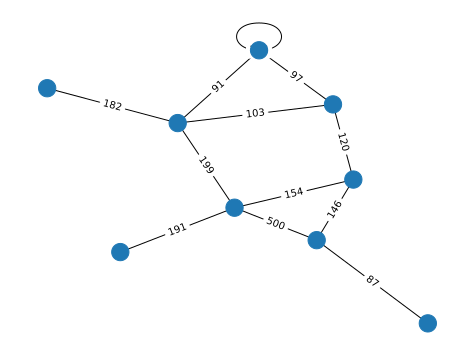

In [28]:
for nx_graph in nx_graphs:
    pos = nx.spring_layout(nx_graph, seed=2760) 
    nx.draw(nx_graph, pos)
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels={
        (f, s): l['weight']
        for f, s, l in nx_graph.edges.data()
    })
    plt.savefig('data/graph_example.svg', bbox_inches='tight')
    plt.show()